# Project 'WikiShop' GLOVO

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries-and-Data" data-toc-modified-id="Libraries-and-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries and Data</a></span></li><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data pre-processing</a></span><ul class="toc-item"><li><span><a href="#Cleaning-the-corpus" data-toc-modified-id="Cleaning-the-corpus-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cleaning the corpus</a></span></li><li><span><a href="#Stopwords" data-toc-modified-id="Stopwords-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Stopwords</a></span></li><li><span><a href="#Lemmatizer" data-toc-modified-id="Lemmatizer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Lemmatizer</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#GloVe-Word-Embeddings-+-PyTorch-Networks" data-toc-modified-id="GloVe-Word-Embeddings-+-PyTorch-Networks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>GloVe Word Embeddings + PyTorch Networks</a></span><ul class="toc-item"><li><span><a href="#Create-Tokenizer-and-Load-GloVe-'840B'-Embeddings" data-toc-modified-id="Create-Tokenizer-and-Load-GloVe-'840B'-Embeddings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create Tokenizer and Load GloVe '840B' Embeddings</a></span></li><li><span><a href="#Train,-test-splitting-and-create-dataloaders" data-toc-modified-id="Train,-test-splitting-and-create-dataloaders-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Train, test splitting and create dataloaders</a></span></li><li><span><a href="#Define-Network" data-toc-modified-id="Define-Network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Define Network</a></span></li></ul></li><li><span><a href="#TF-IDF-+-ML-algorithms" data-toc-modified-id="TF-IDF-+-ML-algorithms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TF-IDF + ML algorithms</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Catboost-Classifier" data-toc-modified-id="Catboost-Classifier-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Catboost Classifier</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Resume" data-toc-modified-id="Resume-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Resume</a></span></li></ul></div>

Wikishop online store launches a new service. Now users can edit and supplement product descriptions like in wiki communities. That is, customers offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation.

You have at your disposal a dataset with markup on the toxicity of edits.

**Project Objective:**

Develop a model for categorizing comments into positive and negative comments.

**Task conditions:**

The value of quality metric F1 is at least 0.75.

## Libraries and Data

In [10]:
import re
import string
import time

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
from tqdm import notebook

from collections import defaultdict
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, ParameterGrid, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score, classification_report, accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

import gc

import warnings
warnings.filterwarnings("ignore")


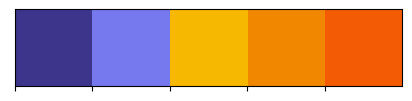

In [11]:
from matplotlib.colors import ListedColormap

class clr:
    S = '\033[1m' + '\033[93m'
    E = '\033[0m'

my_colors = ['#3D348B', '#7678ED', '#F7B801', '#F18701', '#F35B04']
CMAP1 = ListedColormap(my_colors)

sns.palplot(sns.color_palette(my_colors))

In [12]:
server_path = '/datasets/toxic_comments.csv. '
local_path= 'toxic_comments (1).csv'

try:
    data = pd.read_csv(server_path, index_col=0)
except:
    data = pd.read_csv(local_path, index_col=0)

In [13]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [14]:
# take a look at the class ratio
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [15]:
# Toxic comment
print(clr.S+"Toxic comment example: "+ clr.E + data[data['toxic']==1]['text'].values[0])
# Non-toxic comment
print(clr.S+"Non-toxic comment example: "+ clr.E + data[data['toxic']==0]['text'].values[0])

Toxic comment example: COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Non-toxic comment example: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


## Data pre-processing

### Cleaning the corpus

In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
data['text_clean'] = data['text'].apply(clean_text)
data.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


### Stopwords

In [18]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

data['text_clean'] = data['text_clean'].apply(remove_stopwords)
data.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,daww matches background colour seemingly stuck...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestions improvement wonde...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats


### Lemmatizer

In [10]:
lemmatizer = WordNetLemmatizer()

def lem_text(text):
    text = ' '.join(lemmatizer. lemmatize(word) for word in text.split(' '))
    return text

In [11]:
data['text_clean'] = data['text_clean'].apply(lem_text)
data.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,daww match background colour seemingly stuck t...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestion improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats


## EDA

In [19]:
data['text_len'] = data['text_clean'].astype(str).apply(len)
data['text_word_count'] = data['text_clean'].apply(lambda x: len(str(x).split()))
data.head()

,text,toxic,text_clean,text_len,text_word_count
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...,171,25
1,D'aww! He matches this background colour I'm s...,0,daww matches background colour seemingly stuck...,74,10
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...,141,21
3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestions improvement wonde...,384,49
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats,35,6


In [20]:
data['text_word_count'].describe()

count    159292.000000
mean         33.888795
std          52.328398
min           0.000000
25%           8.000000
50%          18.000000
75%          37.000000
max        1250.000000
Name: text_word_count, dtype: float64

In [21]:
toxic = data[data.toxic==1]
non_toxic = data[data.toxic==0]

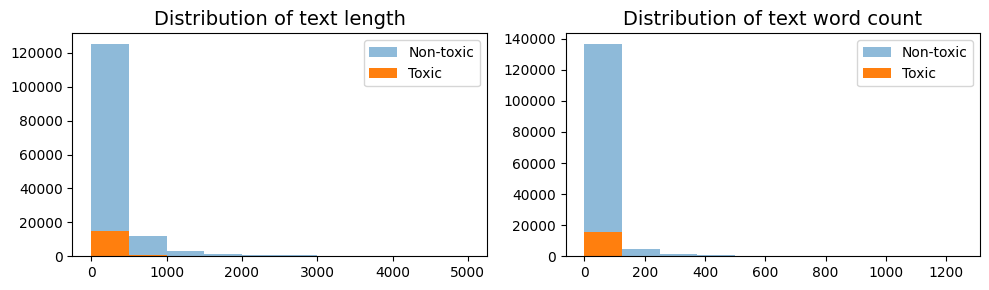

In [22]:
f,ax=plt.subplots(1,2, figsize=(10,3))
ax[0].hist(non_toxic.text_len, alpha=0.5, label='Non-toxic')
ax[0].hist(toxic.text_len, label='Toxic')
ax[0].legend()
ax[0].set_title("Distribution of text length", fontsize=14)

ax[1].hist(non_toxic.text_word_count, alpha=0.5, label='Non-toxic')
ax[1].hist(toxic.text_word_count, label='Toxic')
ax[1].legend()
ax[1].set_title("Distribution of text word count", fontsize=14)
f.tight_layout()

Non-toxic comments are longer than toxic comments

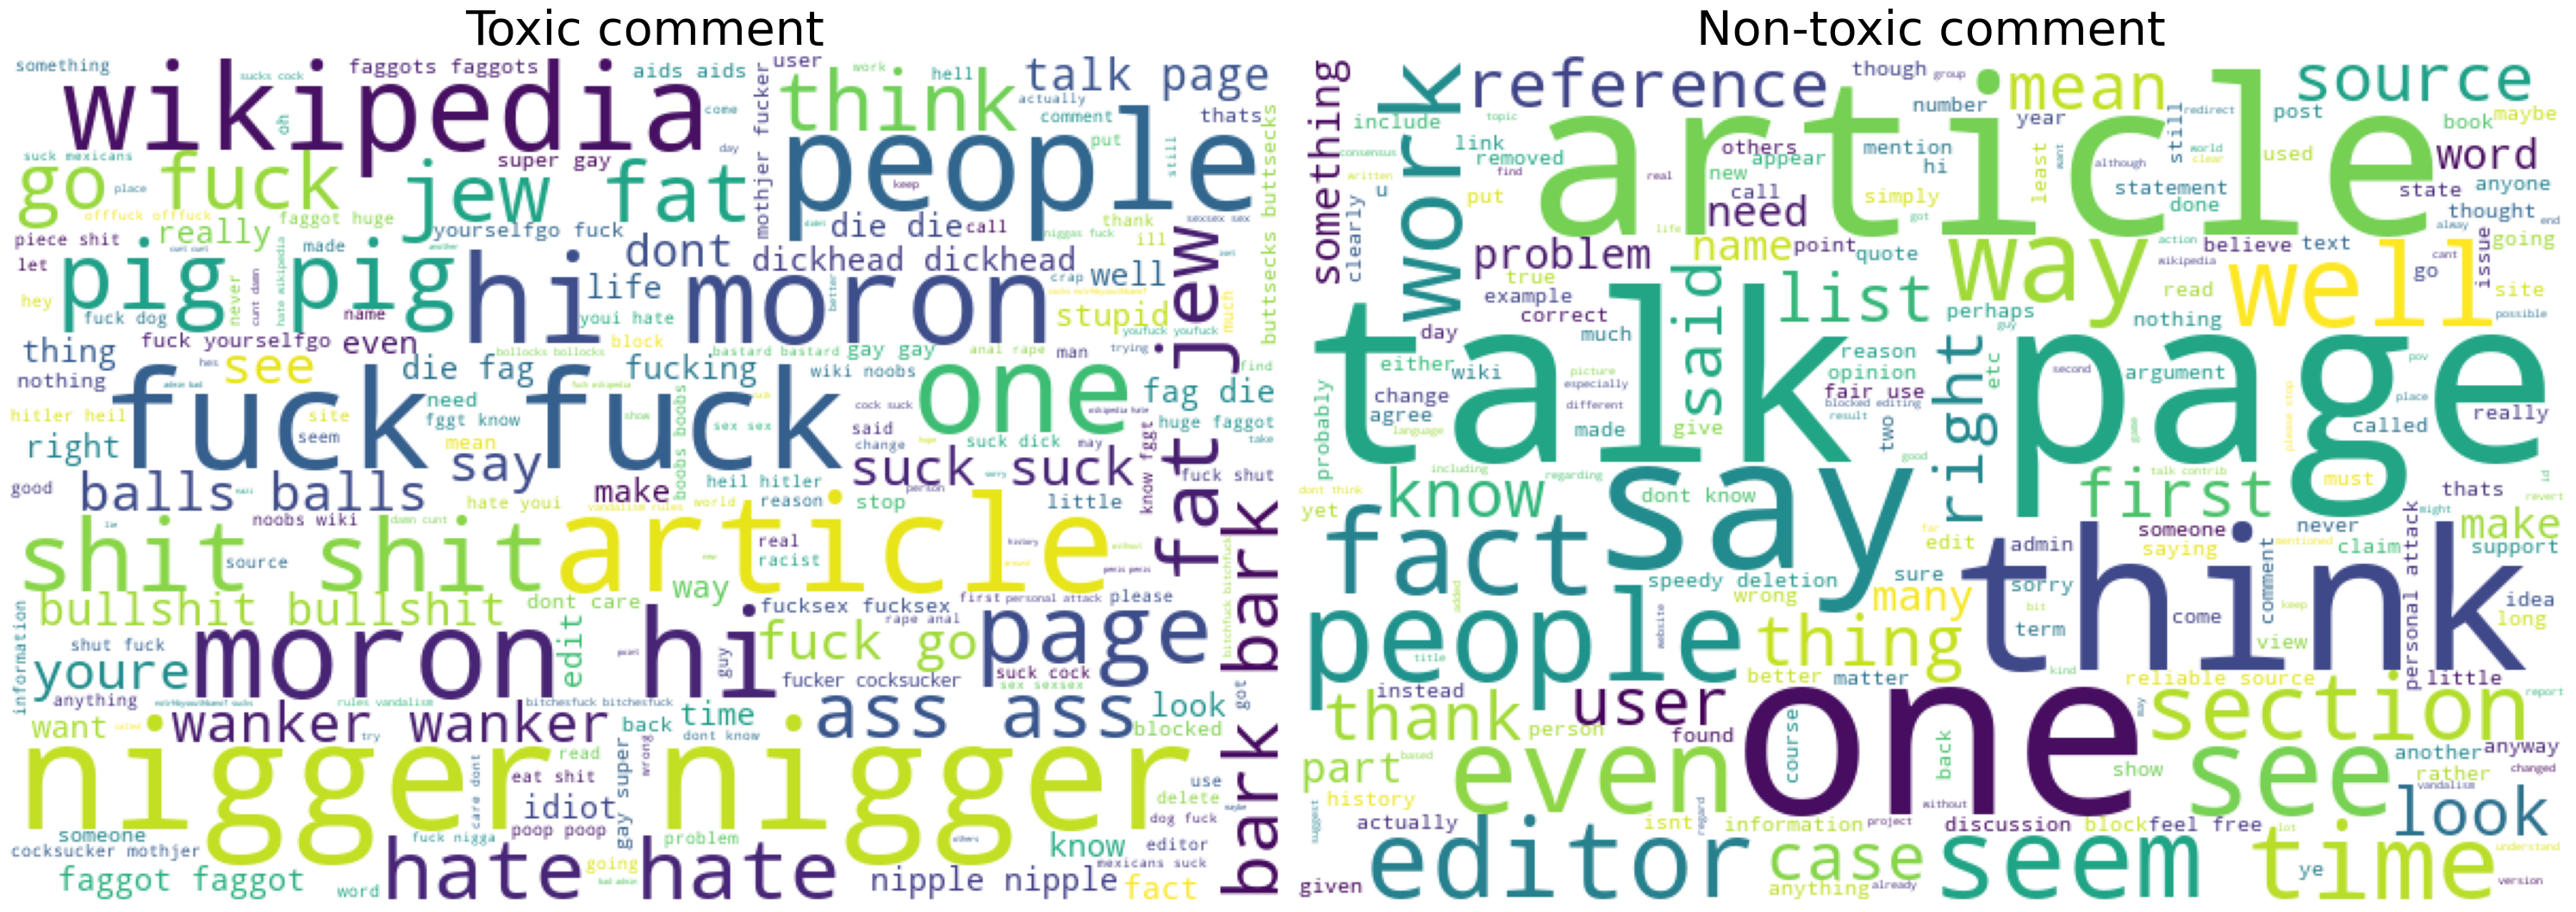

In [23]:
f, ax = plt.subplots(1, 2, figsize=[30, 15])
wordcloud1 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(toxic.text_clean))
ax[0].imshow(wordcloud1)
ax[0].axis('off')
ax[0].set_title('Toxic comment',fontsize=40)

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_toxic.text_clean))
ax[1].imshow(wordcloud2)
ax[1].axis('off')
ax[1].set_title('Non-toxic comment',fontsize=40)
f.tight_layout()

## GloVe Word Embeddings + PyTorch Networks

### Create Tokenizer and Load GloVe '840B' Embeddings

In [20]:
# use tokenizer available from PyTorch
tokenizer = get_tokenizer("basic_english")
tokenizer(data['text_clean'][0])

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'werent',
 'vandalism',
 'closure',
 'gas',
 'voted',
 'new',
 'york',
 'doll',
 'fac',
 'please',
 'dont',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 'retired']

In [21]:
# load GloVe embeddings
global_vectors = GloVe(name='840B', dim=300)

In [22]:
embeddings = global_vectors.get_vecs_by_tokens(tokenizer(data.text_clean[0]), lower_case_backup=True)

embeddings.shape

torch.Size([25, 300])

In [23]:
embeddings

tensor([[-0.6368,  0.1278, -0.4542,  ...,  0.2504,  0.2868, -0.0627],
        [-0.6749, -0.6200, -0.1919,  ..., -0.1629, -0.4687,  0.1929],
        [-0.1471,  0.2076, -0.2159,  ...,  0.1074,  0.0707,  0.4333],
        ...,
        [-0.1781,  0.2526,  0.1247,  ..., -0.3645,  0.2697,  0.3198],
        [ 0.2241,  0.2371,  0.0935,  ..., -0.0704,  0.0972, -0.0200],
        [ 0.7106,  0.1237,  0.1267,  ...,  0.0820, -0.3101, -0.4898]])

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


### Train, test splitting and create dataloaders

In [25]:
x_train, x_test, y_train, y_test = train_test_split(data.text_clean.values, data.toxic.values,
                                                    train_size=0.8, random_state=67, shuffle=True)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test,
                                                    train_size=0.5, random_state=67, shuffle=True)

train_dataset=list(zip(x_train, y_train))
test_dataset=list(zip(x_test, y_test))
valid_dataset=list(zip(x_valid, y_valid))

In [26]:
max_words = 50
embed_len = 300

In [27]:
def collate_batch(batch):
    label_list, text_list = [], []

    for (_text,_label) in batch:
        label_list.append(_label)
        tokenized_text = tokenizer(_text)
        padded_text = tokenized_text + ['']*(max_words-len(tokenized_text)) if len(tokenized_text)<max_words else tokenized_text[:max_words]
        processed_text = torch.zeros(max_words, embed_len)

        for i, token in enumerate(padded_text):
            processed_text[i] = global_vectors.get_vecs_by_tokens(token)
        processed_text = processed_text.flatten()
        text_list.append(processed_text)

    text = torch.stack(text_list).to(device)
    label = torch.tensor(label_list, dtype=torch.int64).to(device)
    return text,label


In [28]:
batch_size=256
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_batch)

In [29]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break


torch.Size([256, 15000]) torch.Size([256])


### Define Network

In [30]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(max_words*embed_len, 4096),
            nn.ReLU(),

            nn.Linear(4096,1024),
            nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 2),
        ).to(device)

    def forward(self, X_batch):
        return self.seq(X_batch)

In [31]:
# calculates the loss and accuracy of the trained model on the validation dataset at the end of each epoch
results_valid = np.array([])
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    global results_valid
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
              
        print("Valid Loss : {:.4f}".format(torch.tensor(losses).mean().cpu().detach().numpy()))
        print("Valid Acc  : {:.4f}".format(f1_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())))
        results_valid = np.append(results_valid, f1_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy()))

In [32]:
results_train = np.array([])
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    global results_train 
    
    for i in range(1, epochs+1):
        shuffled, preds, losses = [],[],[]
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)
            
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())
            
            shuffled.append(Y)
            preds.append(Y_preds.argmax(dim=-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        shuffled = torch.cat(shuffled)
        preds = torch.cat(preds)
        
        if i%3==0:
            print("Train Loss : {:.4f}".format(torch.tensor(losses).mean().cpu().detach().numpy()))
            print('Train Acc : {:.4f}'.format(f1_score(shuffled.cpu().detach().numpy(), preds.cpu().detach().numpy())))
            results_train = np.append(results_train, f1_score(shuffled.cpu().detach().numpy(), preds.cpu().detach().numpy()))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)
            

In [33]:
epochs = 30
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)


In [60]:
TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

100%|██████████| 498/498 [02:12<00:00,  3.76it/s]


Train Loss : 0.0522
Train Acc : 0.9089
Valid Loss : 0.2730
Valid Acc  : 0.7044


100%|██████████| 498/498 [01:58<00:00,  4.21it/s]


Train Loss : 0.0176
Train Acc : 0.9731
Valid Loss : 0.3652
Valid Acc  : 0.7318


100%|██████████| 498/498 [02:11<00:00,  3.79it/s]


Train Loss : 0.0153
Train Acc : 0.9819
Valid Loss : 0.4505
Valid Acc  : 0.7049


100%|██████████| 498/498 [02:10<00:00,  3.83it/s]


Train Loss : 0.0105
Train Acc : 0.9909
Valid Loss : 0.6504
Valid Acc  : 0.7134


100%|██████████| 498/498 [07:47<00:00,  1.07it/s]   


Train Loss : 0.0110
Train Acc : 0.9900
Valid Loss : 0.3298
Valid Acc  : 0.7215


100%|██████████| 498/498 [03:51<00:00,  2.16it/s]  


Train Loss : 0.0106
Train Acc : 0.9925
Valid Loss : 0.3849
Valid Acc  : 0.7251


100%|██████████| 498/498 [2:01:51<00:00, 14.68s/it]      


Train Loss : 0.0040
Train Acc : 0.9943
Valid Loss : 0.4216
Valid Acc  : 0.7281


100%|██████████| 498/498 [13:40<00:00,  1.65s/it]    


Train Loss : 0.0044
Train Acc : 0.9937
Valid Loss : 0.4620
Valid Acc  : 0.7273


100%|██████████| 498/498 [02:18<00:00,  3.58it/s]


Train Loss : 0.0048
Train Acc : 0.9953
Valid Loss : 0.5026
Valid Acc  : 0.7421


100%|██████████| 498/498 [02:41<00:00,  3.08it/s]  


Train Loss : 0.0042
Train Acc : 0.9943
Valid Loss : 0.4865
Valid Acc  : 0.7351


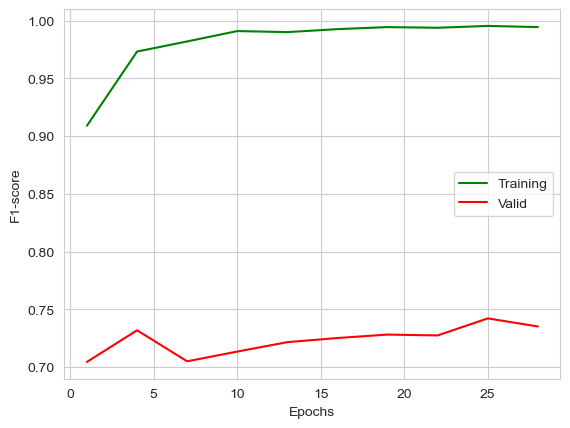

In [62]:
epochs = np.arange(1, 31, 3)
plt.plot(epochs, results_train, 'g', label='Training')
plt.plot(epochs, results_valid, 'r', label='Valid')
plt.ylabel('F1-score')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [34]:
import pickle
# with open('model_new.pkl', 'wb') as f:
#     pickle.dump(embed_classifier, f)

with open('model_new.pkl', 'rb') as f:
    embed_classifier_new = pickle.load(f)

In [35]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

Y_true, Y_preds = MakePredictions(embed_classifier, test_loader)

In [36]:
print('*' * 32)
print(clr.S+f'.: Neural Net w/ GloVo Report :.'+clr.E)
print('*' * 32)
print('F1 Score: '+ clr.S + '{0:.3%}'.format(f1_score(Y_true, Y_preds))+clr.E)
print('Precision: '+ clr.S + '{0:.3%}'.format(precision_score(Y_true, Y_preds))+clr.E)
print('Recall: '+ clr.S + '{0:.3%}'.format(recall_score(Y_true, Y_preds))+clr.E)
print('Roc-Auc: '+ clr.S + '{0:.3%}'.format(roc_auc_score(Y_true, Y_preds))+clr.E)

********************************
.: Neural Net w/ GloVo Report :.
********************************
F1 Score: 18.431%
Precision: 10.204%
Recall: 95.176%
Roc-Auc: 50.271%


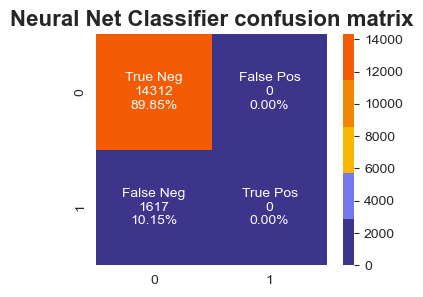

In [37]:
nn_matrix = confusion_matrix(Y_true, Y_preds)
fig = plt.figure(figsize=(4, 3))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in nn_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in nn_matrix.flatten() / np.sum(nn_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(nn_matrix, annot=labels, fmt='', cmap=my_colors, annot_kws={"size": 10}, square=True)
plt.title('Neural Net Classifier confusion matrix', size=16, weight="bold")
plt.show()

## TF-IDF + ML algorithms

- Use TF-IDF for comment vectorization
- Train Logistic Regression and CatBoostClassifier

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data.text_clean, data.toxic,
                                                    train_size=0.8, random_state=67, shuffle=True)

In [13]:
vec = TfidfVectorizer(ngram_range=(1, 1),  max_df=0.75, min_df=3, sublinear_tf=True)
tfidf = vec.fit_transform(x_train)
tfidf_test = vec.transform(x_test)


In [14]:
tfidf.shape

(127433, 40946)

In [15]:
y_train.shape

(127433,)

### Logistic Regression

In [16]:
clf = LogisticRegression(random_state=42, max_iter=500)

scores = cross_val_score(clf, tfidf, y_train, cv=5, scoring='f1')
print("Simple Logistic Regression - F1-score: %0.5f " % (scores.mean()))

Simple Logistic Regression - F1-score: 0.72651 


Select hyperparameters using GridSearchCV

In [22]:
lr = LogisticRegression(random_state=42)
lr_parameters = {'penalty':['l1','l2'],
                  'C':np.logspace(-3,3,4),
                 'max_iter': (100, 500, 1000),
                 'solver':['newton-cg', 'lbfgs', 'liblinear']}

lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_parameters, n_jobs=-1, cv=5, scoring='f1')

# storing the values
lr_grid_result = lr_grid_search.fit(tfidf, y_train)
# printing the best parameters
print("F1-score for LogisticRegression: %f using %s" % (lr_grid_result.best_score_, lr_grid_result.best_params_))

/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

F1-score for LogisticRegression: 0.777775 using {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


**After hyperparameter fitting, the F1-score increased from 72.6% to 77.7%**

### Catboost Classifier

In [18]:
cb_simple = CatBoostClassifier(random_state=42, auto_class_weights='Balanced', verbose = None, logging_level = 'Silent')
scores = cross_val_score(cb_simple, tfidf, y_train, cv=5, scoring='f1')
print("Simple Catboost classifier - F1 score: %0.5f " % (scores.mean()))

Simple Catboost classifier - F1 score: 0.75454 


In [14]:
cb = CatBoostClassifier(random_state=42, auto_class_weights='Balanced', verbose=10)


grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = cb.randomized_search(grid,
                                                X=tfidf,
                                                y=y_train)

0:	learn: 0.6552058	test: 0.6549557	best: 0.6549557 (0)	total: 242ms	remaining: 4m 1s
10:	learn: 0.5460329	test: 0.5455649	best: 0.5455649 (10)	total: 1.61s	remaining: 2m 24s
20:	learn: 0.5064172	test: 0.5056059	best: 0.5056059 (20)	total: 2.83s	remaining: 2m 12s
30:	learn: 0.4821888	test: 0.4810640	best: 0.4810640 (30)	total: 4.08s	remaining: 2m 7s
40:	learn: 0.4581102	test: 0.4580416	best: 0.4580416 (40)	total: 5.28s	remaining: 2m 3s
50:	learn: 0.4418795	test: 0.4421853	best: 0.4421853 (50)	total: 6.56s	remaining: 2m 2s
60:	learn: 0.4286816	test: 0.4306569	best: 0.4306569 (60)	total: 7.69s	remaining: 1m 58s
70:	learn: 0.4181946	test: 0.4201357	best: 0.4201357 (70)	total: 8.83s	remaining: 1m 55s
80:	learn: 0.4092350	test: 0.4116779	best: 0.4116779 (80)	total: 9.99s	remaining: 1m 53s
90:	learn: 0.4003945	test: 0.4019784	best: 0.4019784 (90)	total: 11.2s	remaining: 1m 51s
100:	learn: 0.3939010	test: 0.3961198	best: 0.3961198 (100)	total: 12.3s	remaining: 1m 49s
110:	learn: 0.3867291	tes

In [15]:
randomized_search_result

{'params': {'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [17]:
cb_cv = CatBoostClassifier(random_state=42, 
                           auto_class_weights='Balanced', 
                           verbose=50, depth=10, 
                           l2_leaf_reg=3, 
                           learning_rate=0.1)
scores = cross_val_score(cb_cv, tfidf, y_train, cv=5, scoring='f1')
print("Simple Catboost classifier - F1 score: %0.5f " % (scores.mean()))

0:	learn: 0.6410812	total: 1.35s	remaining: 22m 33s
50:	learn: 0.3799412	total: 1m 11s	remaining: 22m 11s
100:	learn: 0.3335879	total: 2m 20s	remaining: 20m 54s
150:	learn: 0.2945193	total: 3m 30s	remaining: 19m 43s
200:	learn: 0.2659445	total: 4m 42s	remaining: 18m 42s
250:	learn: 0.2451300	total: 5m 55s	remaining: 17m 40s
300:	learn: 0.2289820	total: 7m 8s	remaining: 16m 35s
350:	learn: 0.2150806	total: 8m 24s	remaining: 15m 32s
400:	learn: 0.2034200	total: 9m 38s	remaining: 14m 24s
450:	learn: 0.1934728	total: 10m 52s	remaining: 13m 14s
500:	learn: 0.1844028	total: 12m 6s	remaining: 12m 3s
550:	learn: 0.1761445	total: 13m 19s	remaining: 10m 51s
600:	learn: 0.1685088	total: 14m 29s	remaining: 9m 37s
650:	learn: 0.1613707	total: 15m 46s	remaining: 8m 27s
700:	learn: 0.1553409	total: 16m 55s	remaining: 7m 13s
750:	learn: 0.1495552	total: 18m 5s	remaining: 5m 59s
800:	learn: 0.1435918	total: 19m 15s	remaining: 4m 46s
850:	learn: 0.1387103	total: 20m 24s	remaining: 3m 34s
900:	learn: 0.1

**After hyperparameter fitting, F1-score increased from 75.7 to 76.9%**

## Testing

LogisticRegression performed best in cross validation. Check it on the test sample.

In [20]:
lr = lr_grid_search.best_estimator_

lr.fit(tfidf, y_train)
lr_pred = lr.predict(tfidf_test)
print('*' * 32)
print(clr.S+f'.: Logistic Regression Report :.'+clr.E)
print('*' * 32)
print('F1 Score: '+ clr.S + '{0:.3%}'.format(f1_score(y_test, lr_pred))+clr.E)
print('Precision: '+ clr.S + '{0:.3%}'.format(precision_score(y_test, lr_pred))+clr.E)
print('Recall: '+ clr.S + '{0:.3%}'.format(recall_score(y_test, lr_pred))+clr.E)
print('Roc-Auc: '+ clr.S + '{0:.3%}'.format(roc_auc_score(y_test, lr_pred))+clr.E)

********************************
.: Logistic Regression Report :.
********************************
F1 Score: 78.265%
Precision: 87.457%
Recall: 70.822%
Roc-Auc: 84.834%


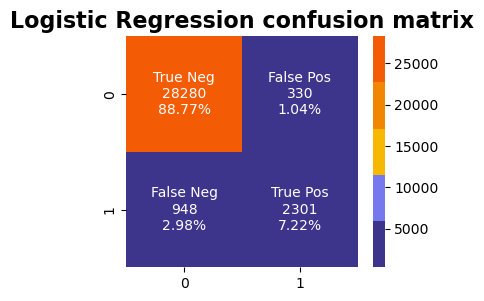

In [21]:
lr_matrix = confusion_matrix(y_test, lr_pred)
fig = plt.figure(figsize=(4,3))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in lr_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f'{v1}\n{v2}\n{v3}'for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap=my_colors,  annot_kws={"size":10}, square=True)
plt.title('Logistic Regression confusion matrix', size=16, weight="bold" )
plt.show()

## Resume

The goal of this project was to train a model to classify comments into positive and negative comments with a value of quality metric F1 of at least 0.75.

1) Comments were converted into embeddings using GloVe. A simple fully connected neural network with 4 linear layers was trained.
2) Comments were vectorized using Tf-IDF. LogisticRegression and CatBoost models with hyperparameter selection were trained.
3) At this stage on the test sample, LogisticRegression performed best with F1=78.265%
